# CHALLENGE 3: The Stationarity

**The Problem:** Neural Networks *hate* trends. If you feed raw prices (100, 105, 110) into an LSTM, it will overfit and fail. It needs "Stationary" data (constant mean/variance).

**Mission:**
1. **Import** `adfuller` from `statsmodels.tsa.stattools`.
2. **Run the Augmented Dickey-Fuller Test** on your 'Close' prices.
3. **Analyze the p-value:** If it is > 0.05, the test fails (Non-Stationary).
4. **Transform the data** (Differencing or Log Returns) until p-value < 0.05.


##What is Stationarity?

A **stationary** time series is one whose statistical properties do not change over time. For a model to learn effectively, it needs data that isn't "moving the goalposts" with constant trends.

### **Three Pillars of Stationarity:**
1. **Constant Mean:** The average value doesn't drift up or down over time.
2. **Constant Variance:** The "swing" or volatility of the data remains stable.
3. **No Seasonality:** There are no predictable, repeating patterns based on time.

**Why Stocks Fail:** Stock prices are almost always **non-stationary** because they trend. However, stock **returns** (the change in price) are often stationary.

### **Resources:**
* [Stationarity in Time Series Analysis (Towards Data Science)](https://towardsdatascience.com/stationarity-in-time-series-a-comprehensive-guide-8beabe20d68/)
* [Detailed Guide to the Augmented Dickey-Fuller (ADF) Test](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import yfinance as yf

# Fetch real stock data
print("Fetching Apple stock data...")
df = yf.download('AAPL', start='2023-01-01', end='2024-12-31', progress=False)

print(f"✅ Downloaded {len(df)} days of data")
print(df.head())

Fetching Apple stock data...
✅ Downloaded 501 days of data
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.211205  128.954553  122.324579  128.343772  112117500
2023-01-04  124.482040  126.747861  123.221065  125.004162   89113600
2023-01-05  123.161949  125.871079  122.905819  125.240591   80962700
2023-01-06  127.693581  128.353621  123.033882  124.137239   87754700
2023-01-09  128.215683  131.427242  127.959553  128.530934   70790800


/tmp/ipython-input-1533583579.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2023-01-01', end='2024-12-31', progress=False)


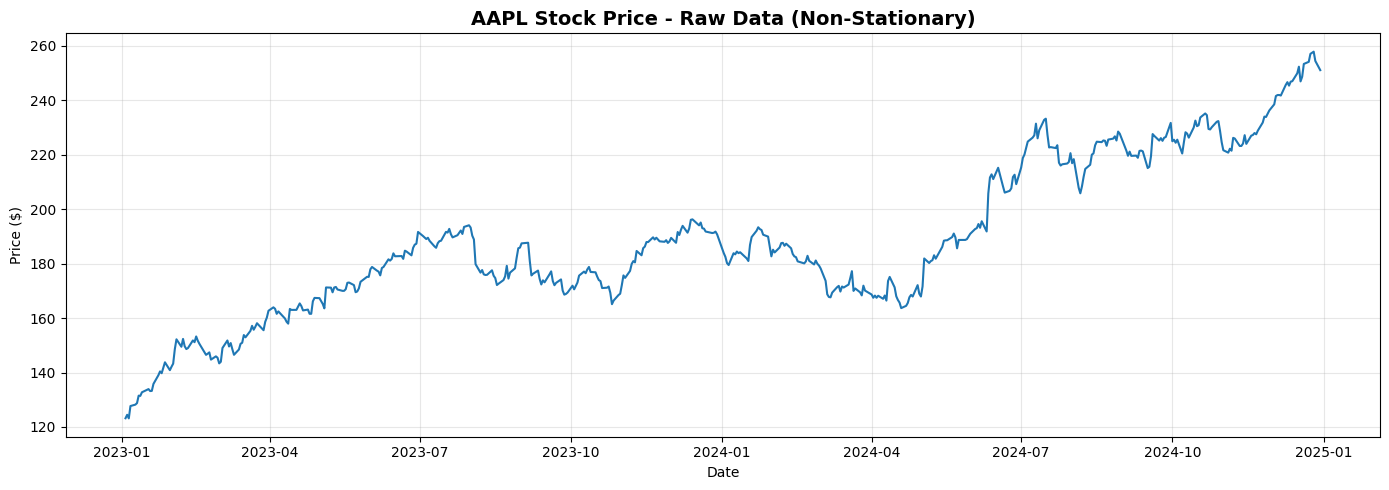

Notice the clear upward trend? That's non-stationarity!


In [20]:
# Plot raw closing prices
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'])
plt.title('AAPL Stock Price - Raw Data (Non-Stationary)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice the clear upward trend? That's non-stationarity!")

## Step 2: The Augmented Dickey-Fuller (ADF) Test
The ADF test is a statistical "gatekeeper."
* **Null Hypothesis ($H_0$):** The data has a unit root (is non-stationary).
* **P-Value < 0.05:** We reject the null hypothesis; the data is **Stationary**.

In [21]:
def perform_adf_test(series, name='Series'):
    """
    Perform Augmented Dickey-Fuller test and print results.
    """
    result = adfuller(series.dropna())

    print(f"\n{'='*60}")
    print(f"ADF Test Results for: {name}")
    print(f"{'='*60}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"P-value: {result[1]:.6f}")
    print(f"Number of lags used: {result[2]}")
    print(f"Number of observations: {result[3]}")
    print(f"\nCritical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")

    print(f"\n{'='*60}")
    if result[1] < 0.05:
        print(f"✅ PASS: p-value < 0.05 → Data is STATIONARY")
    else:
        print(f"❌ FAIL: p-value > 0.05 → Data is NON-STATIONARY")
        print(f"   ⚠️  You cannot train an LSTM on this data!")
    print(f"{'='*60}\n")

    return result[1]  # Return p-value

# Test raw prices
p_value_raw = perform_adf_test(df['Close'], 'Raw Close Prices')


ADF Test Results for: Raw Close Prices
ADF Statistic: -1.126504
P-value: 0.704388
Number of lags used: 1
Number of observations: 499

Critical Values:
  1%: -3.444
  5%: -2.867
  10%: -2.570

❌ FAIL: p-value > 0.05 → Data is NON-STATIONARY
   ⚠️  You cannot train an LSTM on this data!



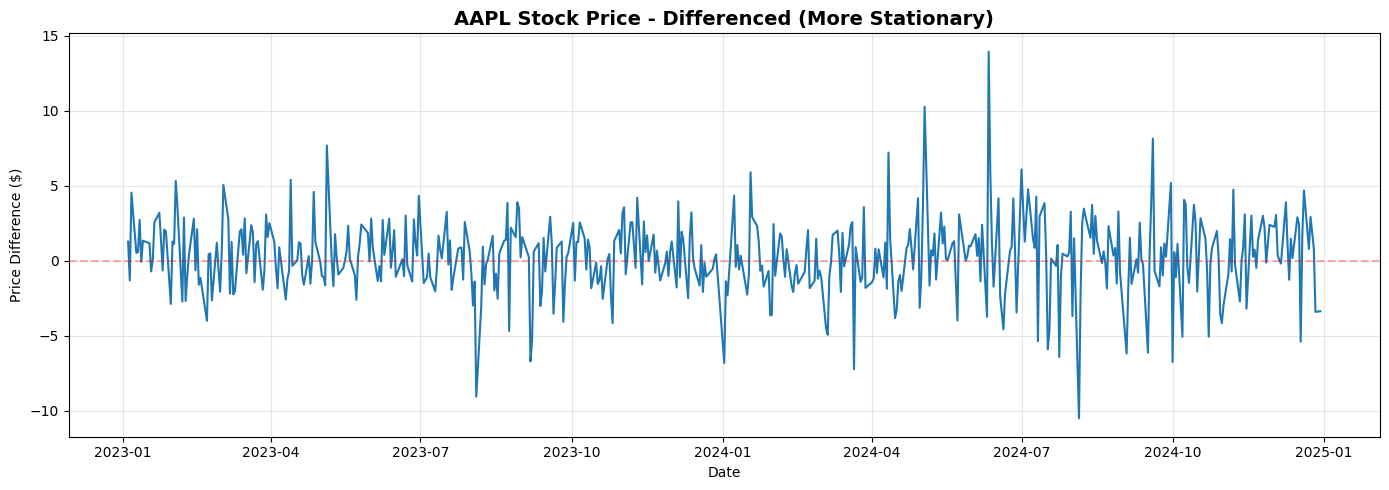

Notice: No clear trend, oscillates around 0!

ADF Test Results for: Differenced Prices
ADF Statistic: -20.863915
P-value: 0.000000
Number of lags used: 0
Number of observations: 499

Critical Values:
  1%: -3.444
  5%: -2.867
  10%: -2.570

✅ PASS: p-value < 0.05 → Data is STATIONARY



In [22]:
# Calculate first difference (today - yesterday)
df['Price_Diff'] = df['Close'].diff()

# Plot differenced data
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Price_Diff'])
plt.title('AAPL Stock Price - Differenced (More Stationary)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice: No clear trend, oscillates around 0!")

# Test differenced data
# Ensure the series is not empty after dropping NaNs before passing to adfuller
differenced_series = df['Price_Diff'].dropna()
if differenced_series.empty:
    print("Error: Differenced series is empty after dropping NaNs. Cannot perform ADF test.")
    p_value_diff = None
else:
    p_value_diff = perform_adf_test(differenced_series, 'Differenced Prices')

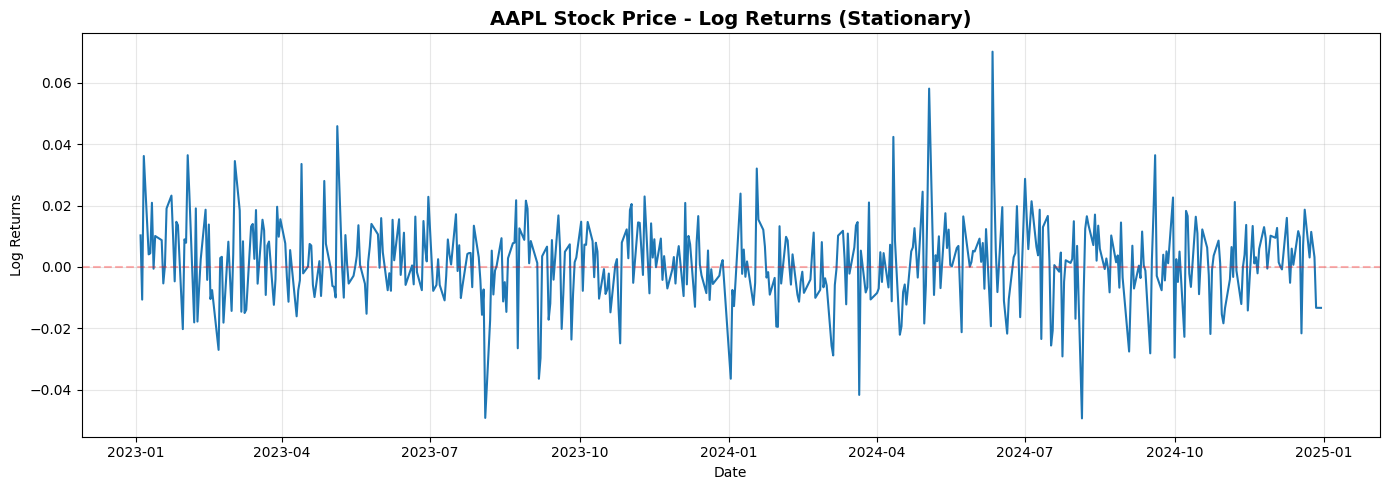

Notice: No clear trend, oscillates around 0!

ADF Test Results for: Log Returns
ADF Statistic: -20.935512
P-value: 0.000000
Number of lags used: 0
Number of observations: 499

Critical Values:
  1%: -3.444
  5%: -2.867
  10%: -2.570

✅ PASS: p-value < 0.05 → Data is STATIONARY



In [23]:
# Calculate log returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Plot log returns
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Log_Returns'])
plt.title('AAPL Stock Price - Log Returns (Stationary)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice: No clear trend, oscillates around 0!")

# Step 4: Run ADF Test on Log Returns
# Ensure the series is not empty after dropping NaNs before passing to adfuller
log_series = df['Log_Returns'].dropna()

if log_series.empty:
    print("Error: Log series is empty after dropping NaNs. Cannot perform ADF test.")
    p_value_log = None
else:
    # We pass the clean series to the function
    p_value_log = perform_adf_test(log_series, 'Log Returns')

In [24]:
# Summary comparison
results_df = pd.DataFrame({
    'Method': ['Raw Prices', 'Differencing', 'Log Returns'],
    'P-Value': [p_value_raw, p_value_diff, p_value_log],
    'Stationary': [p_value_raw < 0.05, p_value_diff < 0.05, p_value_log < 0.05]
})

results_df['Status'] = results_df['Stationary'].apply(lambda x: '✅ PASS' if x else '❌ FAIL')

print("\n" + "="*60)
print("SUMMARY: Stationarity Test Results")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


SUMMARY: Stationarity Test Results
      Method  P-Value  Stationary Status
  Raw Prices 0.704388       False ❌ FAIL
Differencing 0.000000        True ✅ PASS
 Log Returns 0.000000        True ✅ PASS
